In [1]:
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import csv

import numpy as np
from collections import defaultdict
from datetime import datetime, timezone, timedelta

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#label font
# font family normal not found. Falling back to whatever is default
font = {'family' : 'sans-serif',
        # 'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#color palette
plt.style.use("seaborn-v0_8-colorblind")

#figure size
default_figsize = (10,4)
matplotlib.rcParams["figure.figsize"] = default_figsize

/tmp/ipykernel_205455/2881039261.py:51: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sentiment_df['week'] = sentiment_df['date'].dt.to_period('W').dt.start_time  # Convert to weekly bins


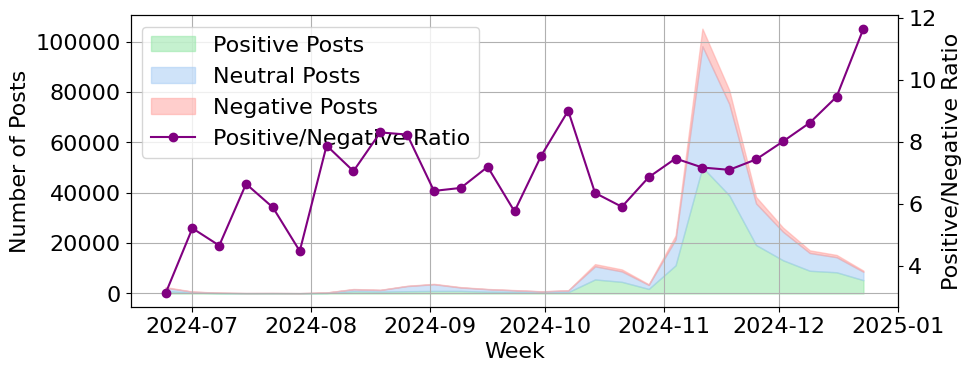

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns

colors = {
    "negative": sns.color_palette("pastel")[3],  # Subtle light red
    "neutral": sns.color_palette("pastel")[0],  # Subtle light blue
    "positive": sns.color_palette("pastel")[2],  # Subtle light green
}

mentions_file_path = "../data/post_containing_mention_of_starter_packs/starter_pack_mentions_in_posts.csv"

mentions_data = pd.read_csv(mentions_file_path)

def perform_sentiment_analysis(mentions_data):
    sentiment_over_time = []
    for _, row in mentions_data.iterrows():
        post_text = row.get("post_text", "")
        post_created_at = row.get("post_created_at", "")
        
        blob = TextBlob(post_text)
        sentiment_polarity = blob.sentiment.polarity
        
        if sentiment_polarity > 0.1:
            sentiment = "Positive"
        elif sentiment_polarity < -0.1:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"
        
        # Store sentiment and date
        sentiment_over_time.append({
            "date": post_created_at,
            "sentiment": sentiment
        })
    
    return sentiment_over_time

sentiment_over_time = perform_sentiment_analysis(mentions_data)

sentiment_df = pd.DataFrame(sentiment_over_time)

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], utc=True, errors='coerce')

sentiment_df = sentiment_df.dropna(subset=['date'])

start_date = pd.Timestamp('2024-06-26', tz='UTC')
sentiment_df = sentiment_df[sentiment_df['date'] >= start_date]

sentiment_df['week'] = sentiment_df['date'].dt.to_period('W').dt.start_time  # Convert to weekly bins
weekly_sentiment = sentiment_df.groupby(['week', 'sentiment']).size().unstack(fill_value=0)

weekly_sentiment['positive_negative_ratio'] = weekly_sentiment['Positive'] / weekly_sentiment['Negative']

fig, ax1 = plt.subplots()

ax1.fill_between(weekly_sentiment.index, 0, weekly_sentiment['Positive'], 
                 label='Positive Posts', color=colors['positive'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, weekly_sentiment['Positive'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 label='Neutral Posts', color=colors['neutral'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'] + weekly_sentiment['Negative'], 
                 label='Negative Posts', color=colors['negative'], alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(weekly_sentiment.index, weekly_sentiment['positive_negative_ratio'], 
         label='Positive/Negative Ratio', color='purple', marker='o')

ax1.set_xlabel('Week', fontweight='normal')
ax1.set_ylabel('Number of Posts', fontweight='normal')
ax2.set_ylabel('Positive/Negative Ratio', fontweight='normal')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.grid(True)
plt.tight_layout()

plt.show()

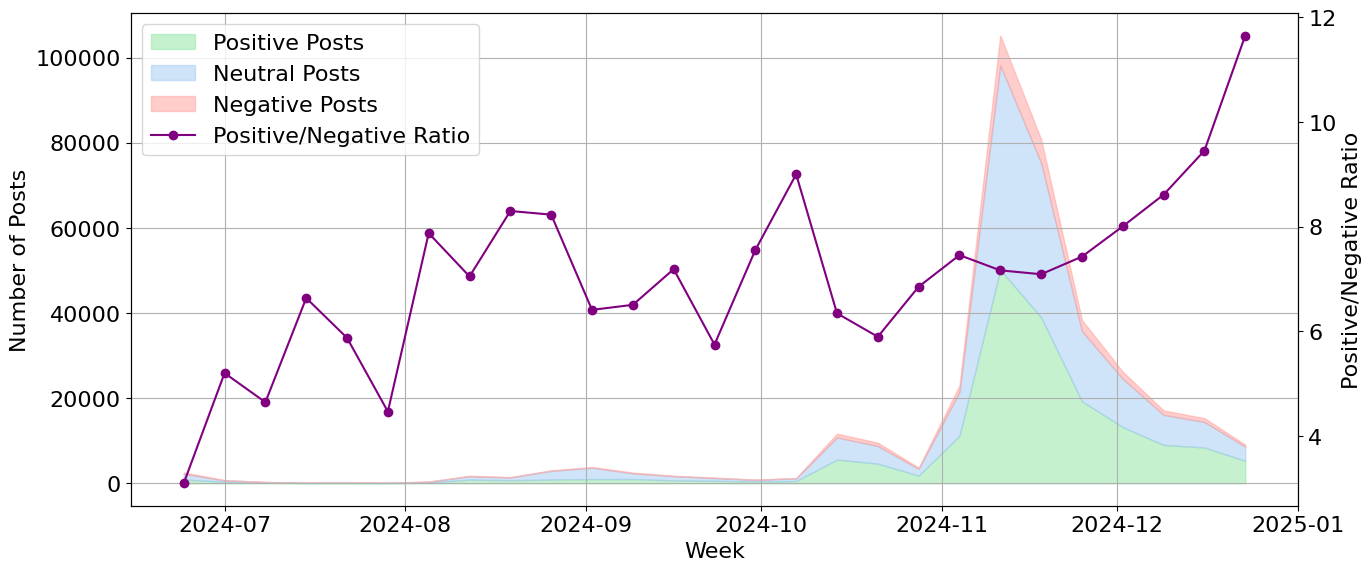

In [3]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.fill_between(weekly_sentiment.index, 0, weekly_sentiment['Positive'], 
                 label='Positive Posts', color=colors['positive'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, weekly_sentiment['Positive'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 label='Neutral Posts', color=colors['neutral'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'] + weekly_sentiment['Negative'], 
                 label='Negative Posts', color=colors['negative'], alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(weekly_sentiment.index, weekly_sentiment['positive_negative_ratio'], 
         label='Positive/Negative Ratio', color='purple', marker='o')

ax1.set_xlabel('Week', fontweight='normal')
ax1.set_ylabel('Number of Posts', fontweight='normal')
ax2.set_ylabel('Positive/Negative Ratio', fontweight='normal')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
from html import unescape

df = pd.read_csv('output_results.csv')

df['most_popular_label'] = df['most_popular_label'].apply(unescape)

df['most_popular_label'] = df['most_popular_label'].str.split('|')
df_exploded = df.explode('most_popular_label')

df_filtered = df_exploded.dropna(subset=['percentage_of_labeled_post'])

top_labels = df_filtered['most_popular_label'].value_counts().head(5).index.tolist()

df_filtered['label_category'] = df_filtered['most_popular_label'].apply(lambda x: x if x in top_labels else 'others')

plt.figure(figsize=(10, 6))

colors = ['red', 'blue', 'green', 'orange', 'purple']
legend_texts = []
for label, color in zip(top_labels, colors):
    label_data = df_filtered[df_filtered['most_popular_label'] == label]
    plt.scatter(label_data['total_posts'].astype(int), 
                label_data['percentage_of_labeled_post'].astype(float), 
                label=label, color=color, zorder=2)
    legend_texts.append(f"{label}: {color}")

# Plot 'others' category with gray color and reduced opacity
others_data = df_filtered[df_filtered['label_category'] == 'others']
plt.scatter(others_data['total_posts'].astype(int), 
            others_data['percentage_of_labeled_post'].astype(float), 
            label='others', color='gray', alpha=0.5, zorder=1)
legend_texts.append("others: gray")

plt.xlabel('Total Posts')
plt.ylabel('% of Labeled Posts')

plt.margins(x=0.01, y=0.01)

plt.legend()

print("Legend:")
for text in legend_texts:
    print(text)

plt.show()


In [5]:

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

file_path = "../data/starter_packs/user_on_boarding.csv"  
df = pd.read_csv(file_path)

df['on_boarded_users'] = df['on_boarded_users'].str.split(';')

df['user_count'] = df['on_boarded_users'].apply(len)

starter_pack_counts = df[['starterpack', 'user_count']].sort_values(by='user_count', ascending=False)

total_onboarded_users = df['user_count'].sum()

starter_pack_counts['percentage_of_total'] = (starter_pack_counts['user_count'] / total_onboarded_users) * 100

def display_top_n_starter_packs(n):
    top_n = starter_pack_counts.head(n)
    print(f"\nTop {n} Most Joined Starter Packs:")
    print(top_n)
    print(f"Total Percentage of Joins: {top_n['percentage_of_total'].sum():.2f}%")

display_top_n_starter_packs(10)
display_top_n_starter_packs(5)
display_top_n_starter_packs(2)
display_top_n_starter_packs(1)

print("\nTotal Onboarded Users Across All Starter Packs:", total_onboarded_users)


Top 10 Most Joined Starter Packs:
                                                                         starterpack  \
2639  at://did:plc:gchmzqms7ibr2fkpzggmufoe/app.bsky.graph.starterpack/3lbd5pkdx7l2o   
345   at://did:plc:dowtmtjlqnvusd23wvjp4m3i/app.bsky.graph.starterpack/3las5ls3v2x2n   
263   at://did:plc:pjiafkey2cokiupsxpswqlk7/app.bsky.graph.starterpack/3lazeus5cvh27   
323   at://did:plc:d3rehtj2m7lm3m6nxs33dkhh/app.bsky.graph.starterpack/3lawj666rjl2e   
547   at://did:plc:xz44ynrglmmooqtxqbdl4ubh/app.bsky.graph.starterpack/3latd43l3ym2u   
293   at://did:plc:apo2t7ketcjpsxsdtrbzhyzo/app.bsky.graph.starterpack/3lapf22krd52n   
476   at://did:plc:yobyqjt4hs5icoihvaombhhn/app.bsky.graph.starterpack/3l44geftjy72j   
268   at://did:plc:ikvnfuw3l3kqoatcadcmii6b/app.bsky.graph.starterpack/3layngdoukp2z   
269   at://did:plc:whmdtfaoue7x2xxgl4cch3dm/app.bsky.graph.starterpack/3lawibu3ufd2i   
495   at://did:plc:zivbusxwcsom5o6mf7kljzms/app.bsky.graph.starterpack/3l7jgum7g5g2g 

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
import plotly.graph_objects as go
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random

# Download NLTK data (only needed once)
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
file_path = "../data/output/starterpacks_with_classifications_istanbul_1.csv"
df = pd.read_csv(file_path)

# Function to generate random colors
def generate_random_color():
    return f"rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 0.6)"

# Function to normalize text and map singular to plural
def normalize_classification(text, is_starter_pack=False):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r"-.*", "", text).strip()
    if "n/a" in text or "unknown" in text:
        return ""
    # Remove all punctuation (including full stops)
    text = re.sub(r"[^\w\s]", "", text)
    
    # Map singular to plural forms
    singular_to_plural = {
        "social media": "social media",  # Keep as is (already plural)
        "media": "media",                # Keep as is
        "art": "arts",                   # Singular to plural
        "science": "sciences",           # Singular to plural
        "technology": "technologies",    # Singular to plural
        "business": "businesses",        # Singular to plural
    }
    
    for singular, plural in singular_to_plural.items():
        if singular == text:
            text = plural
            break
    
    if is_starter_pack and (text == "social media" or text == "media"):
        text = "generic"
    
    return text

# Apply normalization to starter_pack_classification and participants_classification columns
df["cleaned_starter_pack"] = df["starter_pack_classification"].apply(
    lambda x: normalize_classification(x, is_starter_pack=True)  # Apply replacement for starter packs
)
df["cleaned_participants"] = df["participants_classification"].apply(normalize_classification)

# Remove rows where cleaned classifications are empty
df = df[(df["cleaned_starter_pack"] != "") & (df["cleaned_participants"] != "")]

def group_similar_classifications(classifications, threshold=0.7):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(classifications)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    groups = defaultdict(list)
    used_indices = set()
    
    for i, classification in enumerate(classifications):
        if i not in used_indices:
            groups[classification].append(classification)
            for j in range(i + 1, len(classifications)):
                if similarity_matrix[i, j] >= threshold:
                    groups[classification].append(classifications[j])
                    used_indices.add(j)
    return groups

starter_pack_groups = group_similar_classifications(df["cleaned_starter_pack"].unique())
participant_groups = group_similar_classifications(df["cleaned_participants"].unique())

def map_to_group(text, groups):
    for group, members in groups.items():
        if text in members:
            return group
    return text

df["grouped_starter_pack"] = df["cleaned_starter_pack"].apply(lambda x: map_to_group(x, starter_pack_groups))
df["grouped_participants"] = df["cleaned_participants"].apply(lambda x: map_to_group(x, participant_groups))

min_threshold = 5
starter_pack_counts = df["grouped_starter_pack"].value_counts()
participant_counts = df["grouped_participants"].value_counts()

df = df[
    (df["grouped_starter_pack"].isin(starter_pack_counts[starter_pack_counts >= min_threshold].index)) &
    (df["grouped_participants"].isin(participant_counts[participant_counts >= min_threshold].index))
]

# Limit to the top N classifications
top_n = 15
top_starter_packs = starter_pack_counts.head(top_n).index
top_participants = participant_counts.head(top_n).index

df = df[
    (df["grouped_starter_pack"].isin(top_starter_packs)) &
    (df["grouped_participants"].isin(top_participants))
]

starter_pack_classes = df["grouped_starter_pack"].unique()
participant_classes = df["grouped_participants"].unique()

starter_pack_class_map = {label: idx for idx, label in enumerate(starter_pack_classes)}
participant_class_map = {label: idx + len(starter_pack_classes) for idx, label in enumerate(participant_classes)}

df["source"] = df["grouped_starter_pack"].map(starter_pack_class_map)
df["target"] = df["grouped_participants"].map(participant_class_map)

source_target_pairs = list(zip(df["source"], df["target"]))
source_target_counts = pd.DataFrame(source_target_pairs, columns=["source", "target"]).value_counts().reset_index(name="value")

labels = list(starter_pack_class_map.keys()) + list(participant_class_map.keys())
# Replace "social media" and "media" with "generic" in the labels (for display purposes only)
# Define mappings for generic categories
def map_to_generic_labels(label):
    # User-related terms are mapped to "participants"
    # user_related_terms = ["user", "social media", "media", "users", "individual", "researcher", "scholar"]
    # if label in user_related_terms:
    #     return "participants"
    
    social_related_terms = ["social media", "media", "users", "individuals"]
    if label in social_related_terms:
        return "generic"
    
    creator_related_terms = ["creator", "content creator", "artists"]
    if label in creator_related_terms:
        return "artists"
    
    return label

labels = [map_to_generic_labels(label) for label in labels]

colors = [generate_random_color() for _ in range(len(source_target_counts))]

node_colors = defaultdict(list)
for idx, (source, target, value) in enumerate(source_target_counts.itertuples(index=False, name=None)):
    node_colors[source].append((colors[idx], value))  
    node_colors[target].append((colors[idx], value)) 

def get_dominant_color(color_value_pairs):
    color_weights = defaultdict(float)
    for color, value in color_value_pairs:
        color_weights[color] += value
    
    dominant_color = max(color_weights, key=color_weights.get)
    return dominant_color

node_colors_dominant = [get_dominant_color(node_colors[i]) if i in node_colors else "rgba(200, 200, 200, 0.6)" for i in range(len(labels))]

sankey_fig = go.Figure(go.Sankey(
    node=dict(
        pad=10,  # Reduce padding between nodes
        thickness=15,  # Adjust node thickness
        line=dict(color="black", width=0.5),
        label=labels, 
        color=node_colors_dominant
    ),
    link=dict(
        source=source_target_counts["source"],
        target=source_target_counts["target"],
        value=source_target_counts["value"],
        color=colors  
    )
))

sankey_fig.update_layout(
    width=1400,  # Set figure width
    height=900,  # Set figure height
    margin=dict(l=10, r=10, t=10, b=10),  # Reduce margins
    hovermode="x unified",
    font=dict(size=20)  # Set global text size
)

sankey_fig.write_image("sankey_diagram.png", scale=2)  # Increase scale for higher resolution

sankey_fig.show()

[nltk_data] Downloading package wordnet to /Users/machine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/machine/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import pandas as pd
import plotly.graph_objects as go
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict, Counter
import random

file_path = "../data/classified_posts/classified_starter_packs_hpc.csv"
df = pd.read_csv(file_path)

def normalize_classification(text, is_starter_pack=False):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r"-.*", "", text).strip()
    if "n/a" in text or "unknown" in text:
        return ""
    text = re.sub(r"[^\w\s]", "", text)

    singular_to_plural = {
        "art": "arts",
    }
    for singular, plural in singular_to_plural.items():
        if singular == text:
            text = plural
            break

    # Shared rule: anything with "anti" goes to activism
    if "anti" in text:
        return "activism"

    if is_starter_pack:
        starter_keywords = {"social media", "media", "social"}
        if any(keyword in text for keyword in starter_keywords):
            return "generic"
        if "creative" in text or "anime" in text:
            return "art"
        
        if "news aggregator" in text: 
            return "news"
        
        if "political" in text: 
            return "politics"
        
    else:
        participant_keywords = {
            "friend", "individual", "fan", "influencer",
            "user", "users", "social media", "social circle", "community", "people", "consumers", "learners"
        }
        if any(keyword in text for keyword in participant_keywords):
            return "generic"
        if "creator" in text or "creative" in text:
            return "artists"

    return text

df["cleaned_starter_pack"] = df["starter_pack_classification"].apply(
    lambda x: normalize_classification(x, is_starter_pack=True)
)
df["cleaned_participants"] = df["participants_classification"].apply(normalize_classification)

df = df[(df["cleaned_starter_pack"] != "") & (df["cleaned_participants"] != "")]

# Semantic clustering
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def cluster_and_label_semantic(labels, n_clusters=30, side="starter_pack"):
    embeddings = embedder.encode(labels, convert_to_tensor=False)
    clustering_model = AgglomerativeClustering(distance_threshold=1.0, n_clusters=None)
    cluster_labels = clustering_model.fit_predict(embeddings)

    clusters = defaultdict(list)
    for label, cluster_id in zip(labels, cluster_labels):
        clusters[cluster_id].append(label)

    rep_map = {}
    for cluster_id, members in clusters.items():
        if any(m in {"generic", "artists", "activism"} for m in members):
            representative = [m for m in members if m in {"generic", "artists", "activism"}][0]
        else:
            counts = Counter(df[df[f"cleaned_{side}"].isin(members)][f"cleaned_{side}"])
            representative = counts.most_common(1)[0][0] if counts else members[0]
        for m in members:
            rep_map[m] = representative

    return rep_map

# starter_pack_map = cluster_and_label_semantic(df["cleaned_starter_pack"].unique(), n_clusters=30, side="starter_pack")
# participant_map = cluster_and_label_semantic(df["cleaned_participants"].unique(), n_clusters=30, side="participants")

df["grouped_starter_pack"] = df["cleaned_starter_pack"]
df["grouped_participants"] = df["cleaned_participants"]

# Filter top 20 most frequent
top_20_starter_packs = df["grouped_starter_pack"].value_counts().nlargest(10).index
top_20_participants = df["grouped_participants"].value_counts().nlargest(10).index

df = df[df["grouped_starter_pack"].isin(top_20_starter_packs)]
df = df[df["grouped_participants"].isin(top_20_participants)]

starter_pack_classes = df["grouped_starter_pack"].unique()
participant_classes = df["grouped_participants"].unique()

starter_pack_class_map = {label: idx for idx, label in enumerate(starter_pack_classes)}
participant_class_map = {label: idx + len(starter_pack_classes) for idx, label in enumerate(participant_classes)}

df["source"] = df["grouped_starter_pack"].map(starter_pack_class_map)
df["target"] = df["grouped_participants"].map(participant_class_map)

source_target_counts = (
    df.groupby(["source", "target"])
    .size()
    .reset_index(name="value")
)

min_link_threshold = 100
source_target_counts = source_target_counts[source_target_counts["value"] >= min_link_threshold]

labels = list(starter_pack_class_map.keys()) + list(participant_class_map.keys())

def generate_random_color():
    return f"rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 0.6)"

colors = [generate_random_color() for _ in range(len(source_target_counts))]

node_colors = defaultdict(list)
for idx, (source, target, value) in enumerate(source_target_counts.itertuples(index=False, name=None)):
    node_colors[source].append((colors[idx], value))  
    node_colors[target].append((colors[idx], value)) 

def get_dominant_color(color_value_pairs):
    color_weights = defaultdict(float)
    for color, value in color_value_pairs:
        color_weights[color] += value
    return max(color_weights, key=color_weights.get)

node_colors_dominant = [get_dominant_color(node_colors[i]) if i in node_colors else "rgba(200, 200, 200, 0.6)" for i in range(len(labels))]

sankey_fig = go.Figure(go.Sankey(
    node=dict(
        pad=10,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors_dominant
    ),
    link=dict(
        source=source_target_counts["source"],
        target=source_target_counts["target"],
        value=source_target_counts["value"],
        color=colors
    )
))

sankey_fig.update_layout(
    width=1400,
    height=1000,
    margin=dict(l=10, r=10, t=10, b=10),
    hovermode="x unified",
    font=dict(size=28)
)

sankey_fig.write_image("sankey_diagram_semantic.png", scale=2)
sankey_fig.show()

print("Top cleaned starter packs:", df["cleaned_starter_pack"].value_counts().head(10))
print("Top grouped starter packs:", df["grouped_starter_pack"].value_counts().head(10))


Top cleaned starter packs: cleaned_starter_pack
generic      7833
politics     1721
gaming        995
sports        586
art           539
music         535
activism      523
news          497
lifestyle     257
education     202
Name: count, dtype: int64
Top grouped starter packs: grouped_starter_pack
generic      7833
politics     1721
gaming        995
sports        586
art           539
music         535
activism      523
news          497
lifestyle     257
education     202
Name: count, dtype: int64


In [3]:
import pandas as pd
import plotly.graph_objects as go
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict, Counter
import random

file_path = "../data/classified_posts/classified_starter_packs_hpc.csv"
df = pd.read_csv(file_path)

def normalize_classification(text, is_starter_pack=False):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r"-.*", "", text).strip()
    if "n/a" in text or "unknown" in text:
        return ""
    text = re.sub(r"[^\w\s]", "", text)

    # Normalize singular forms
    singular_to_plural = {
        "art": "arts",
    }
    for singular, plural in singular_to_plural.items():
        if singular == text:
            text = plural
            break

    # Shared rule: anything with "anti" goes to activism
    if "anti" in text:
        return "activism"

    if is_starter_pack:
        starter_keywords = {"social media", "media", "social"}
        if any(keyword in text for keyword in starter_keywords):
            return "generic"
        if "creative" in text or "anime" in text:
            return "art"
    else:
        participant_keywords = {
            "friend", "individual", "fan", "influencer",
            "user", "users", "social media", "social circle", "community", "people", "consumers", "learners"
        }
        if any(keyword in text for keyword in participant_keywords):
            return "generic"
        if "creator" in text or "creative" in text:
            return "artists"

    return text

df["cleaned_starter_pack"] = df["starter_pack_classification"].apply(
    lambda x: normalize_classification(x, is_starter_pack=True)
)
df["cleaned_participants"] = df["participants_classification"].apply(normalize_classification)

df = df[(df["cleaned_starter_pack"] != "") & (df["cleaned_participants"] != "")]

# Semantic clustering
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def cluster_and_label_semantic(labels, n_clusters=30, side="starter_pack"):
    embeddings = embedder.encode(labels, convert_to_tensor=False)
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering_model.fit_predict(embeddings)

    clusters = defaultdict(list)
    for label, cluster_id in zip(labels, cluster_labels):
        clusters[cluster_id].append(label)

    rep_map = {}
    for cluster_id, members in clusters.items():
        counts = Counter(df[df[f"cleaned_{side}"].isin(members)][f"cleaned_{side}"])
        representative = counts.most_common(1)[0][0] if counts else members[0]
        for m in members:
            rep_map[m] = representative

    return rep_map

starter_pack_map = cluster_and_label_semantic(df["cleaned_starter_pack"].unique(), n_clusters=30, side="starter_pack")
participant_map = cluster_and_label_semantic(df["cleaned_participants"].unique(), n_clusters=30, side="participants")

df["grouped_starter_pack"] = df["cleaned_starter_pack"].map(starter_pack_map)
df["grouped_participants"] = df["cleaned_participants"].map(participant_map)

# Filter top 20 most frequent
top_20_starter_packs = df["grouped_starter_pack"].value_counts().nlargest(10).index
top_20_participants = df["grouped_participants"].value_counts().nlargest(10).index

df = df[df["grouped_starter_pack"].isin(top_20_starter_packs)]
df = df[df["grouped_participants"].isin(top_20_participants)]

starter_pack_classes = df["grouped_starter_pack"].unique()
participant_classes = df["grouped_participants"].unique()

starter_pack_class_map = {label: idx for idx, label in enumerate(starter_pack_classes)}
participant_class_map = {label: idx + len(starter_pack_classes) for idx, label in enumerate(participant_classes)}

df["source"] = df["grouped_starter_pack"].map(starter_pack_class_map)
df["target"] = df["grouped_participants"].map(participant_class_map)

source_target_counts = (
    df.groupby(["source", "target"])
    .size()
    .reset_index(name="value")
)

min_link_threshold = 100
source_target_counts = source_target_counts[source_target_counts["value"] >= min_link_threshold]

labels = list(starter_pack_class_map.keys()) + list(participant_class_map.keys())

def generate_random_color():
    return f"rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 0.6)"

colors = [generate_random_color() for _ in range(len(source_target_counts))]

node_colors = defaultdict(list)
for idx, (source, target, value) in enumerate(source_target_counts.itertuples(index=False, name=None)):
    node_colors[source].append((colors[idx], value))  
    node_colors[target].append((colors[idx], value)) 

def get_dominant_color(color_value_pairs):
    color_weights = defaultdict(float)
    for color, value in color_value_pairs:
        color_weights[color] += value
    return max(color_weights, key=color_weights.get)

node_colors_dominant = [get_dominant_color(node_colors[i]) if i in node_colors else "rgba(200, 200, 200, 0.6)" for i in range(len(labels))]

sankey_fig = go.Figure(go.Sankey(
    node=dict(
        pad=10,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors_dominant
    ),
    link=dict(
        source=source_target_counts["source"],
        target=source_target_counts["target"],
        value=source_target_counts["value"],
        color=colors
    )
))

sankey_fig.update_layout(
    width=1400,
    height=1000,
    margin=dict(l=10, r=10, t=10, b=10),
    hovermode="x unified",
    font=dict(size=28)
)

sankey_fig.write_image("sankey_diagram_semantic.png", scale=2)
sankey_fig.show()


In [ ]:
import nltk
import pandas as pd
import plotly.graph_objects as go
import re
import random
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('wordnet')
nltk.download('omw-1.4')

file_path = "../data/classified_posts/classified_starter_packs_hpc.csv"

df = pd.read_csv(file_path)

def generate_random_color():
    return f"rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 0.6)"

def normalize_classification(text):
    if pd.isna(text):
        return "Others"  # Treat NaN as "Others"
    text = text.lower()
    text = re.sub(r"\(.*?\)", "", text)  # Remove parentheses
    text = re.sub(r"-.*", "", text).strip()  # Remove text after dash
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text if text not in ["unknown", "n/a", "na"] else "Others"

df["cleaned_starter_pack"] = df["starter_pack_classification"].apply(normalize_classification)
df["cleaned_participants"] = df["participants_classification"].apply(normalize_classification)

def map_to_generic_labels(label):
    user_related_terms = ["individuals", "users", "user", "people", "social", "social media", "community", "social media users", "personal collection", "friends"]
    creator_related_terms = ["creators", "content creators", "creatives"]
    creative_related_terms = ["creative", "art community", "arts", "art", "artists"]
    
    if label in user_related_terms:
        return "generic"
    elif label in creator_related_terms:
        return "artists"
    elif label in creative_related_terms:
        return "arts"
    
    return label

df["grouped_starter_pack"] = df["cleaned_starter_pack"].apply(map_to_generic_labels)
df["grouped_participants"] = df["cleaned_participants"].apply(map_to_generic_labels)

starter_pack_counts = df["grouped_starter_pack"].value_counts()
participant_counts = df["grouped_participants"].value_counts()

top_n = 15
top_starter_packs = starter_pack_counts.head(top_n).index
top_participants = participant_counts.head(top_n).index

df["grouped_starter_pack"] = df["grouped_starter_pack"].apply(lambda x: x if x in top_starter_packs else "Others")
df["grouped_participants"] = df["grouped_participants"].apply(lambda x: x if x in top_participants else "Others")

starter_pack_counts = df["grouped_starter_pack"].value_counts()
participant_counts = df["grouped_participants"].value_counts()

starter_pack_classes = list(starter_pack_counts.index)
participant_classes = list(participant_counts.index)

if "Others" not in starter_pack_classes:
    starter_pack_classes.append("Others")

if "Others" not in participant_classes:
    participant_classes.append("Others")

starter_pack_class_map = {label: idx for idx, label in enumerate(starter_pack_classes)}
participant_class_map = {label: idx + len(starter_pack_classes) for idx, label in enumerate(participant_classes)}

df["source"] = df["grouped_starter_pack"].map(starter_pack_class_map)
df["target"] = df["grouped_participants"].map(participant_class_map)

source_target_pairs = list(zip(df["source"], df["target"]))
source_target_counts = pd.DataFrame(source_target_pairs, columns=["source", "target"]).value_counts().reset_index(name="value")

if "Others" in starter_pack_class_map and "Others" in participant_class_map:
    dummy_source = starter_pack_class_map["Others"]
    dummy_target = participant_class_map["Others"]
    if not ((source_target_counts["source"] == dummy_source) & (source_target_counts["target"] == dummy_target)).any():
        source_target_counts = pd.concat([
            source_target_counts,
            pd.DataFrame({"source": [dummy_source], "target": [dummy_target], "value": [1]})  # Small flow
        ])

labels = list(starter_pack_class_map.keys()) + list(participant_class_map.keys())

colors = [generate_random_color() for _ in range(len(source_target_counts))]

node_colors = defaultdict(list)
for idx, (source, target, value) in enumerate(source_target_counts.itertuples(index=False, name=None)):
    node_colors[source].append((colors[idx], value))  
    node_colors[target].append((colors[idx], value)) 

def get_dominant_color(color_value_pairs):
    color_weights = defaultdict(float)
    for color, value in color_value_pairs:
        color_weights[color] += value
    return max(color_weights, key=color_weights.get)

node_colors_dominant = [get_dominant_color(node_colors[i]) if i in node_colors else "rgba(200, 200, 200, 0.6)" for i in range(len(labels))]

sankey_fig = go.Figure(go.Sankey(
    node=dict(
        pad=30,
        thickness=15, 
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors_dominant
    ),
    link=dict(
        source=source_target_counts["source"],
        target=source_target_counts["target"],
        value=source_target_counts["value"],
        color=colors  
    )
))

sankey_fig.update_layout(
    width=1400,
    height=1000,
    margin=dict(l=10, r=10, t=10, b=10),
    hovermode="x unified",
    font=dict(size=32)
)

sankey_fig.write_image("sankey_diagram.png", scale=2)
sankey_fig.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import re
from collections import defaultdict, Counter
import random

file_path = "../data/classified_posts/classified_starter_packs_hpc.csv"
df = pd.read_csv(file_path)

def normalize_classification(text, is_starter_pack=False):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r"-.*", "", text).strip()
    if "n/a" in text or "unknown" in text:
        return ""
    text = re.sub(r"[^\w\s]", "", text)

    singular_to_plural = {"art": "arts"}
    for singular, plural in singular_to_plural.items():
        if singular == text:
            text = plural
            break

    if "anti" in text:
        return "activism"

    if is_starter_pack:
        if any(kw in text for kw in {"social media", "media", "social"}):
            return "generic"
        if "creative" in text or "anime" in text:
            return "art"
        if "news aggregator" in text:
            return "news"
        if "political" in text:
            return "politics"
    else:
        if any(kw in text for kw in {"friend", "individual", "fan", "influencer", "user", "users", "social media", "social circle", "community", "people", "consumers", "learners"}):
            return "generic"
        if "creator" in text or "creative" in text:
            return "artists"
    return text

df["cleaned_starter_pack"] = df["starter_pack_classification"].apply(lambda x: normalize_classification(x, is_starter_pack=True))
df["cleaned_participants"] = df["participants_classification"].apply(normalize_classification)

df = df[(df["cleaned_starter_pack"] != "") & (df["cleaned_participants"] != "")]

df["grouped_starter_pack"] = df["cleaned_starter_pack"]
df["grouped_participants"] = df["cleaned_participants"]

top_20_starter_packs = df["grouped_starter_pack"].value_counts().nlargest(10).index
top_20_participants = df["grouped_participants"].value_counts().nlargest(10).index

df = df[df["grouped_starter_pack"].isin(top_20_starter_packs)]
df = df[df["grouped_participants"].isin(top_20_participants)]

starter_pack_classes = df["grouped_starter_pack"].unique()
participant_classes = df["grouped_participants"].unique()

starter_pack_class_map = {label: idx for idx, label in enumerate(starter_pack_classes)}
participant_class_map = {label: idx + len(starter_pack_classes) for idx, label in enumerate(participant_classes)}

df["source"] = df["grouped_starter_pack"].map(starter_pack_class_map)
df["target"] = df["grouped_participants"].map(participant_class_map)

source_target_counts = (
    df.groupby(["source", "target"])
    .size()
    .reset_index(name="value")
)

min_link_threshold = 100
source_target_counts = source_target_counts[source_target_counts["value"] >= min_link_threshold]

total_value = source_target_counts["value"].sum()

link_labels = []
for _, row in source_target_counts.iterrows():
    source_label = list(starter_pack_class_map.keys())[list(starter_pack_class_map.values()).index(row["source"])]
    target_label = list(participant_class_map.keys())[list(participant_class_map.values()).index(row["target"])]
    value = row["value"]
    pct = (value / total_value) * 100
    label = f"{source_label} → {target_label} ({pct:.1f}%)"
    link_labels.append(label)

inflow = defaultdict(int)
outflow = defaultdict(int)

for _, row in source_target_counts.iterrows():
    outflow[row["source"]] += row["value"]
    inflow[row["target"]] += row["value"]

labels = []
for i in range(len(starter_pack_class_map)):
    value = outflow[i]
    percent = (value / total_value) * 100
    label = list(starter_pack_class_map.keys())[i]
    labels.append(f"{label} ({percent:.1f}%)")

for i in range(len(participant_class_map)):
    node_index = i + len(starter_pack_class_map)
    value = inflow[node_index]
    percent = (value / total_value) * 100
    label = list(participant_class_map.keys())[i]
    labels.append(f"{label} ({percent:.1f}%)")

def generate_random_color():
    return f"rgba({random.randint(0,255)}, {random.randint(0,255)}, {random.randint(0,255)}, 0.6)"

colors = [generate_random_color() for _ in range(len(source_target_counts))]

node_colors = defaultdict(list)
for idx, (source, target, value) in enumerate(source_target_counts.itertuples(index=False, name=None)):
    node_colors[source].append((colors[idx], value))
    node_colors[target].append((colors[idx], value))

def get_dominant_color(pairs):
    scores = defaultdict(float)
    for color, value in pairs:
        scores[color] += value
    return max(scores, key=scores.get)

node_colors_dominant = [get_dominant_color(node_colors[i]) if i in node_colors else "rgba(200,200,200,0.6)" for i in range(len(labels))]

fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=10,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors_dominant
    ),
    link=dict(
        source=source_target_counts["source"],
        target=source_target_counts["target"],
        value=source_target_counts["value"],
        color=colors,
        customdata=link_labels,
        hovertemplate='%{customdata}<extra></extra>'
    )
))

fig.update_layout(
    width=1400,
    height=1000,
    margin=dict(l=10, r=10, t=10, b=10),
    hovermode="x unified",
    font=dict(size=34, color="white"),
)

fig.write_image("sankey_with_percentages.png", scale=3)
fig.show()

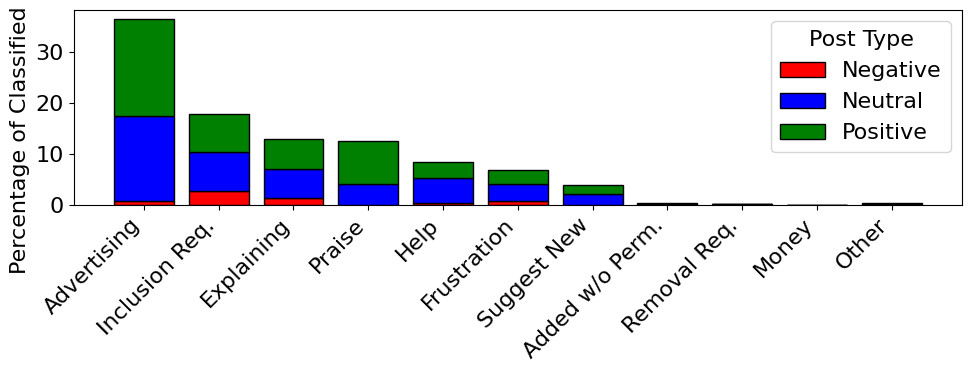

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

file_paths = {
    "negative": "../data/classified_posts/classified_negative_posts_hpc.csv",
    "neutral": "../data/classified_posts/classified_neutral_posts_hpc.csv",
    "positive": "../data/classified_posts/classified_positive_posts_hpc.csv"
}

negative_mapping = {
    1: "Frustration with the current system",
    2: "Asking for help",
    3: "Asking for money",
    4: "Asking to be removed from a starter pack",
    5: "Added without permission",
    6: "Advertising a starter pack",
    7: "Desire to be included in a starter pack",
    8: "Explaining How the System Works or Reporting Starter Pack Experience",
    9: "Other"
}

neutral_mapping = {
    1: "Praising a Starter Pack or Starter Packs in General",
    2: "Explaining How the System Works or Reporting Starter Pack Experience",
    3: "Desire to Be Added to a Starter Pack",
    4: "Advertising a Starter Pack (including asking for members or inviting others to join)",
    5: "Expressing Frustration with the Current System (e.g., mass follow but zero engagement)",
    6: "Added Without Permission",
    7: "Suggesting Someone Create a New Starter Pack",
    8: "Asking for Help (e.g., understanding how the system works or looking for a specific Starter Pack)",
    9: "Asking for money to include someone in a starter pack",
    10: "Other"
}

positive_mapping = neutral_mapping.copy()

short_category_mapping = {
    "Frustration with the current system": "Frustration",
    "Asking for help": "Help",
    "Asking for money": "Money",
    "Asking to be removed from a starter pack": "Removal Req.",
    "Added without permission": "Added w/o Perm.",
    "Advertising a starter pack": "Advertising",
    "Desire to be included in a starter pack": "Inclusion Req.",
    "Other not covered by the above categories": "Other",
    "Praising a Starter Pack or Starter Packs in General": "Praise",
    "Explaining How the System Works or Reporting Starter Pack Experience": "Explaining",
    "Desire to Be Added to a Starter Pack": "Inclusion Req.",
    "Advertising a Starter Pack (including asking for members or inviting others to join)": "Advertising",
    "Expressing Frustration with the Current System (e.g., mass follow but zero engagement)": "Frustration",
    "Added Without Permission": "Added w/o Perm.",
    "Suggesting Someone Create a New Starter Pack": "Suggest New",
    "Asking for Help (e.g., understanding how the system works or looking for a specific Starter Pack)": "Help",
    "Asking for money to include someone in a starter pack": "Money",
    "Other": "Other",
    "Unknown": "Other"
}

def extract_exact_categories(category_text, mapping):
    category_text = str(category_text)  # Ensure it's a string
    numbers = list(map(int, re.findall(r"(?<![\d\$])\b[1-9]\b(?![\d\$])", category_text)))
    if numbers:
        return [mapping.get(num, "Unknown") for num in numbers]
    matched_categories = []
    for num, description in mapping.items():
        if description.lower() in category_text.lower():
            matched_categories.append(description)
    return matched_categories if matched_categories else ["Unknown"]

# Dictionary to store category counts by post type
category_counts = {}

# Process all posts without sampling
for post_type, file_path in file_paths.items():
    data = pd.read_csv(file_path)

    mapping = negative_mapping if post_type == "negative" else neutral_mapping

    data['extracted_categories'] = data['category'].apply(
        lambda x: extract_exact_categories(x, mapping)
    )

    data['short_categories'] = data['extracted_categories'].apply(
        lambda cats: [short_category_mapping.get(cat, "Unknown") for cat in cats]
    )

    all_short_categories = [cat for sublist in data['short_categories'] for cat in sublist]
    category_counts[post_type] = pd.Series(all_short_categories).value_counts()

for post_type in file_paths.keys():
    if post_type not in category_counts:
        category_counts[post_type] = pd.Series(dtype=float)

combined_counts = pd.DataFrame(category_counts).fillna(0)

total_posts = sum(len(pd.read_csv(file)) for file in file_paths.values())

category_percentages = combined_counts / total_posts * 100

category_percentages['total'] = category_percentages.sum(axis=1)
sorted_category_percentages = category_percentages.sort_values(by='total', ascending=False)

if "Other" in sorted_category_percentages.index:
    other_row = sorted_category_percentages.loc["Other"]
    sorted_category_percentages = sorted_category_percentages.drop("Other")
    sorted_category_percentages.loc["Other"] = other_row

colors = {"negative": "red", "neutral": "blue", "positive": "green"}
bottom = np.zeros(len(sorted_category_percentages.index))

for post_type in sorted_category_percentages.columns[:-1]:  
    plt.bar(
        sorted_category_percentages.index,
        sorted_category_percentages[post_type],
        label=post_type.capitalize(),
        bottom=bottom,
        color=colors[post_type],
        edgecolor='black'
    )
    bottom += sorted_category_percentages[post_type].values

plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Classified Posts')
plt.legend(title='Post Type')
plt.tight_layout()
plt.show()

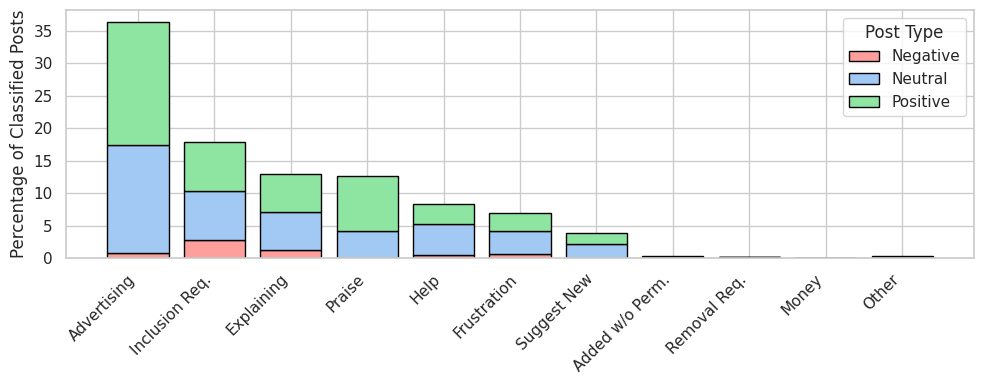

In [7]:
import seaborn as sns

sns.set_theme(style="whitegrid")

colors = {
    "negative": sns.color_palette("pastel")[3],  # Subtle light red
    "neutral": sns.color_palette("pastel")[0],  # Subtle light blue
    "positive": sns.color_palette("pastel")[2],  # Subtle light green
}

bottom = np.zeros(len(sorted_category_percentages.index))
for post_type in sorted_category_percentages.columns[:-1]:  # Exclude 'total' column for plotting
    plt.bar(
        sorted_category_percentages.index,
        sorted_category_percentages[post_type],
        label=post_type.capitalize(),
        bottom=bottom,
        color=colors[post_type],
        edgecolor='black'
    )
    bottom += sorted_category_percentages[post_type].values

plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Classified Posts')
# plt.title('Category Distribution Across Post Types (Sorted by Total Percentage)', fontsize=16)
plt.legend(title='Post Type')
plt.tight_layout()
plt.show()